In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_csv('data/cleaned_student_lifestyle_dataset.csv')

In [3]:
df.head()

,student_id,study_hours_per_day,extracurricular_hours_per_day,sleep_hours_per_day,social_hours_per_day,physical_activity_hours_per_day,gpa,stress_level,stress_level_numeric,gpa_group
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate,2,2.5-3
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low,1,2.5-3
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low,1,2.5-3
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate,2,2.5-3
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High,3,3.5-4


Filter data to include only Low and High stress levels

In [4]:
df_filtered = df[df['stress_level'].isin(['Low', 'High'])]

In [5]:
df_filtered.head()

,student_id,study_hours_per_day,extracurricular_hours_per_day,sleep_hours_per_day,social_hours_per_day,physical_activity_hours_per_day,gpa,stress_level,stress_level_numeric,gpa_group
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low,1,2.5-3
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low,1,2.5-3
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High,3,3.5-4
6,7,8.0,0.7,5.3,5.7,4.3,3.08,High,3,3-3.5
7,8,8.4,1.8,5.6,3.0,5.2,3.20,High,3,3-3.5


Define low and high stress groups

In [6]:
low_stress = df[df['stress_level'] == 'Low']['physical_activity_hours_per_day']
high_stress = df[df['stress_level'] == 'High']['physical_activity_hours_per_day']

Visual exploration of the groups

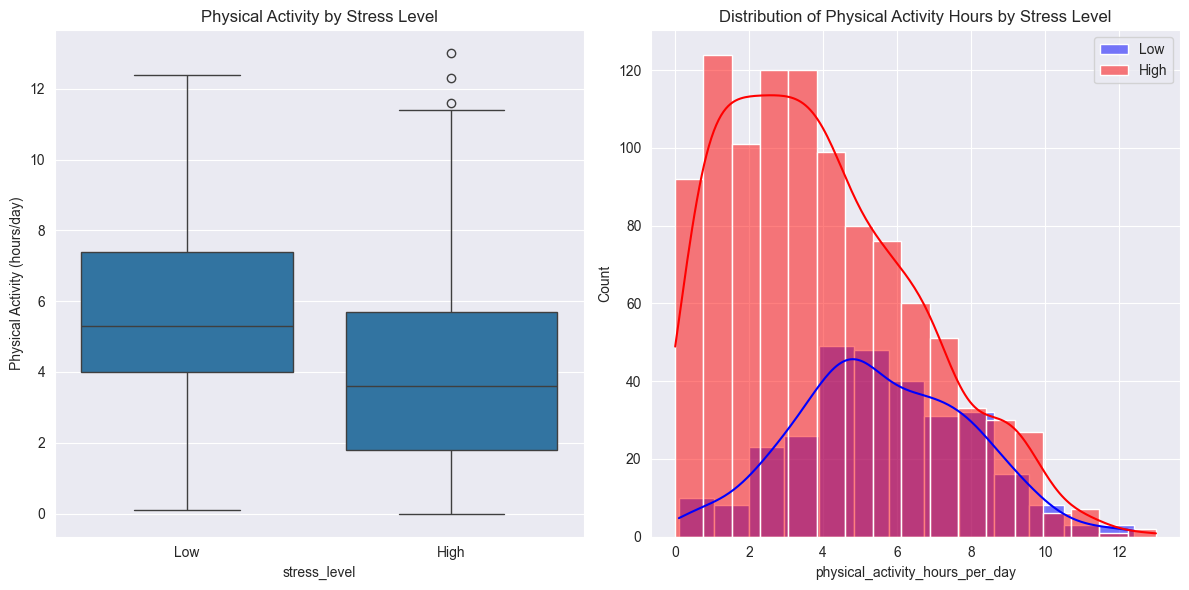

In [7]:
plt.figure(figsize=(12, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='stress_level', y='physical_activity_hours_per_day', data=df_filtered)
plt.title('Physical Activity by Stress Level')
plt.ylabel('Physical Activity (hours/day)')

# Distribution
plt.subplot(1, 2, 2)
for group, color in zip(['Low', 'High'], ['blue', 'red']):
    sns.histplot(df[df['stress_level'] == group]['physical_activity_hours_per_day'],
                kde=True, label=group, color=color, alpha=0.5)
plt.title('Distribution of Physical Activity Hours by Stress Level')
plt.legend()
plt.tight_layout()
plt.show()

Graphs show that low-stress students tend to have higher physical activity hours per day compared to high-stress students. Let's perform a statistical test to confirm this observation.

before test we need to check the normality of the data

Visual check with Q-Q plot

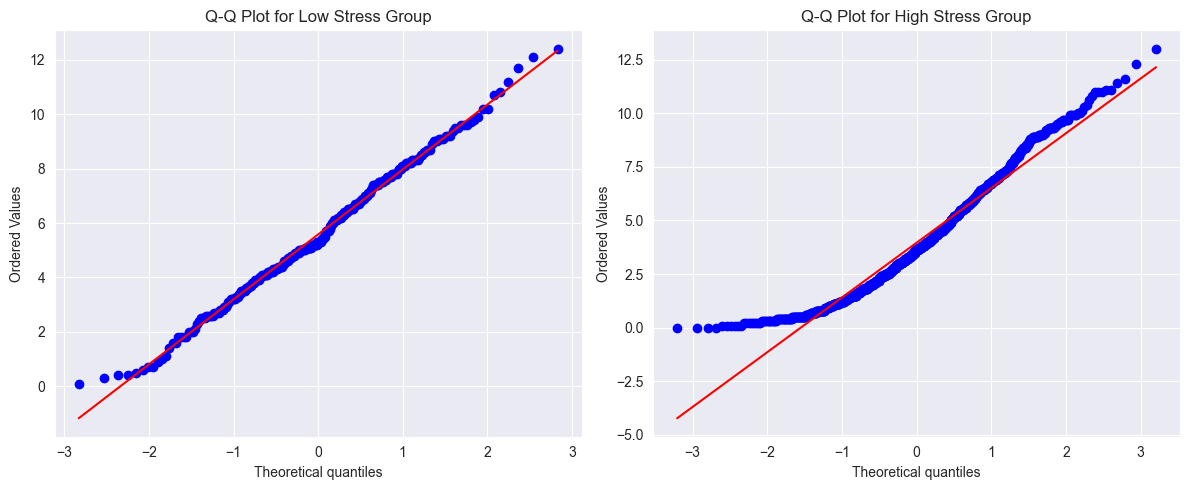

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
stats.probplot(low_stress, dist="norm", plot=plt)
plt.title('Q-Q Plot for Low Stress Group')

plt.subplot(1, 2, 2)
stats.probplot(high_stress, dist="norm", plot=plt)
plt.title('Q-Q Plot for High Stress Group')

plt.tight_layout()
plt.show()

as we saw before the data for high-stress group is not normally distributed, let's use the Shapiro-Wilk test to confirm this

In [9]:
shapiro_low = stats.shapiro(low_stress)
shapiro_high = stats.shapiro(high_stress)
print(f"Low stress group: W={shapiro_low[0]:.4f}, p={shapiro_low[1]:.4f}")
print(f"High stress group: W={shapiro_high[0]:.4f}, p={shapiro_high[1]:.4f}")
print(f"Normality assumption {'violated' if (shapiro_low[1] < 0.05 or shapiro_high[1] < 0.05) else 'satisfied'}")

Low stress group: W=0.9943, p=0.3364
High stress group: W=0.9559, p=0.0000
Normality assumption violated


Yes, if we saw the Q-Q plot and the Shapiro-Wilk test, we can conclude that the normality assumption is violated for the high-stress group. Therefore, we should use a non-parametric test to compare the two groups.

let's apply transformation to the data to make it normally distributed

In [13]:
results = pd.DataFrame(columns=['Transformation', 'Low_W', 'Low_p', 'High_W', 'High_p', 'Normal'])

Original data

In [14]:
def add_shapiro_results(df, transformation_name, shapiro_low, shapiro_high):
    """
    Add Shapiro-Wilk test results to the results dataframe

    Parameters:
    df (DataFrame): Results dataframe to add to
    transformation_name (str): Name of the transformation
    shapiro_low (tuple): Shapiro-Wilk test results for low stress group (W, p-value)
    shapiro_high (tuple): Shapiro-Wilk test results for high stress group (W, p-value)

    Returns:
    DataFrame: Updated results dataframe
    """
    new_row = {
        'Transformation': transformation_name,
        'Low_W': shapiro_low[0],
        'Low_p': shapiro_low[1],
        'High_W': shapiro_high[0],
        'High_p': shapiro_high[1],
        'Normal': 'Yes' if (shapiro_low[1] >= 0.05 and shapiro_high[1] >= 0.05) else 'No'
    }

    return pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


In [15]:
results = pd.DataFrame(columns=['Transformation', 'Low_W', 'Low_p', 'High_W', 'High_p', 'Normal'])


1. log transformation

In [16]:
log_low = np.log(low_stress + 1)
log_high = np.log(high_stress + 1)
results = add_shapiro_results(results, 'Log(x+1)', stats.shapiro(log_low), stats.shapiro(log_high))

/tmp/ipykernel_105850/1894363755.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


2. square root transformation

In [17]:
sqrt_low = np.sqrt(low_stress)
sqrt_high = np.sqrt(high_stress)
results = add_shapiro_results(results, 'Square root', stats.shapiro(sqrt_low), stats.shapiro(sqrt_high))

3. reciprocal transformation

In [18]:
recip_low = 1 / (low_stress + 0.01)  # Adding 0.01 to avoid division by zero
recip_high = 1 / (high_stress + 0.01)
results = add_shapiro_results(results, 'Reciprocal', stats.shapiro(recip_low), stats.shapiro(recip_high))

In [19]:
results

,Transformation,Low_W,Low_p,High_W,High_p,Normal
0,Log(x+1),0.925862,5.450339e-11,0.973857,1.164804e-12,No
1,Square root,0.970239,8.072240e-06,0.990946,5.824928e-06,No
2,Reciprocal,0.222617,2.629157e-33,0.078516,7.558519e-57,No


not complex transformations don't help us to make the data normally distributed, let's apply CLT